In [17]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from transformers import AutoTokenizer, AutoModelForCausalLM

from sdscm import plot_dag_from_sample_space, sample_sequences, format_sequences_as_dataframe, sample_counterfactual_sequences

# Load language model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained('gpt2')

# Define confounder SD-SCM

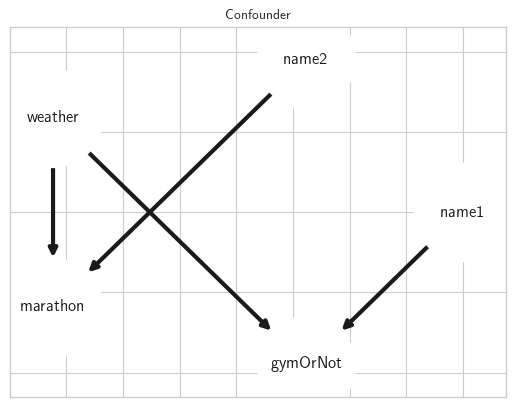

In [4]:
confounder_sample_space = [
    {
        'prefix': 'My name is ',
        'suffix': '.',
        'candidate_set': ['John', 'Jane', 'Alice', 'Bob', 'Charlie'],
        'intervention_choice': None,
        'parent_indices': None,
        'exogenous': True,
        'variable_name': 'name1',
    },
    {
        'prefix': 'I know someone named ',
        'suffix': '.',
        'candidate_set': ['John', 'Jane', 'Alice', 'Bob', 'Charlie'],
        'intervention_choice': 'uniform',
        'parent_indices': None,
        'exogenous': True,
        'variable_name': 'name2',
    },
    {
        'prefix': 'Conditions are ',
        'suffix': ' outside in the open air.',
        'candidate_set': ['sunny', 'rainy', 'snowy', 'cold', 'hot'],
        'intervention_choice': None,
        'parent_indices': None,
        'exogenous': False,
        'variable_name': 'weather',
    },
    {
        'prefix': 'After this, my marathon personal best will ',
        'suffix': '.',
        'candidate_set': ['improve', 'worsen'],
        'intervention_choice': None,
        'parent_indices': [1, 2],
        'exogenous': False,
        'variable_name': 'marathon',
    },
    {
        'prefix': 'I owe it to myself to go ',
        'suffix': '.',
        'candidate_set': ['to the gym', 'for a run outside'],
        'intervention_choice': None,
        'parent_indices': [0, 2],
        'exogenous': False,
        'variable_name': 'gymOrNot',
    },
]

plot_dag_from_sample_space(sequence_sample_space=confounder_sample_space, title='Confounder')

## Sample confounder data

In [5]:
np.random.seed(1)
torch.manual_seed(1)

num_samples = 1000
name_of_intervention = 'gymOrNot'
name_of_outcome = 'marathon'
all_covariates = [setup_dict['variable_name'] for setup_dict in confounder_sample_space]

confounder_samples = sample_sequences(
    model=model,
    tokenizer=tokenizer,
    sequence_sample_space=confounder_sample_space,
    num_samples=num_samples
)

df_samples_confounder = format_sequences_as_dataframe(sequences=confounder_samples, name_of_intervention=name_of_intervention, name_of_outcome=name_of_outcome, save_logprobs=True)
with pd.option_context('display.max_colwidth', None):
    display(df_samples_confounder[['sampled_text']])
    display(df_samples_confounder[all_covariates])

print('Sampling counterfactuals...')
np.random.seed(3)
torch.manual_seed(3)
index_of_intervention = np.where([setup_dict['variable_name'] == name_of_intervention for setup_dict in confounder_sample_space])[0][0]
evidence_indices = [np.where([setup_dict['variable_name'] == 'weather' for setup_dict in confounder_sample_space])[0][0]]
confounder_cf_samples_do_0 = sample_counterfactual_sequences(
    model=model,
    tokenizer=tokenizer,
    sequence_sample_space=confounder_sample_space,
    samples=confounder_samples,
    evidence_indices=evidence_indices,
    index_of_intervention=index_of_intervention,
    intervention_choice=0
)
confounder_cf_samples_do_1 = sample_counterfactual_sequences(
    model=model,
    tokenizer=tokenizer,
    sequence_sample_space=confounder_sample_space,
    samples=confounder_samples,
    evidence_indices=evidence_indices,
    index_of_intervention=index_of_intervention,
    intervention_choice=1
)
df_confounder_cf_samples_do_0 = format_sequences_as_dataframe(sequences=confounder_cf_samples_do_0, name_of_intervention=name_of_intervention, name_of_outcome=name_of_outcome)
df_confounder_cf_samples_do_1 = format_sequences_as_dataframe(sequences=confounder_cf_samples_do_1, name_of_intervention=name_of_intervention, name_of_outcome=name_of_outcome)
print('Done.')

100%|██████████| 1000/1000 [15:05<00:00,  1.10it/s]


,sampled_text
0,"My name is Bob. I know someone named Bob. Conditions are sunny outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."
1,"My name is Jane. I know someone named Charlie. Conditions are snowy outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."
2,"My name is Alice. I know someone named John. Conditions are hot outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."
3,"My name is Bob. I know someone named Jane. Conditions are sunny outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go for a run outside."
4,"My name is Bob. I know someone named Bob. Conditions are sunny outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."
...,...
995,"My name is Jane. I know someone named John. Conditions are hot outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go for a run outside."
996,"My name is Jane. I know someone named John. Conditions are snowy outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."
997,"My name is Alice. I know someone named Charlie. Conditions are hot outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."
998,"My name is Alice. I know someone named Charlie. Conditions are cold outside in the open air. After this, my marathon personal best will worsen. I owe it to myself to go to the gym."


,name1,name2,weather,marathon,gymOrNot
0,3,3,0,1,0
1,1,4,2,1,0
2,2,0,4,1,0
3,3,1,0,1,1
4,3,3,0,1,0
...,...,...,...,...,...
995,1,0,4,1,1
996,1,0,2,1,0
997,2,4,4,1,0
998,2,4,3,1,0


Sampling counterfactuals...


100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


Done.


# Define collider SD-SCM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


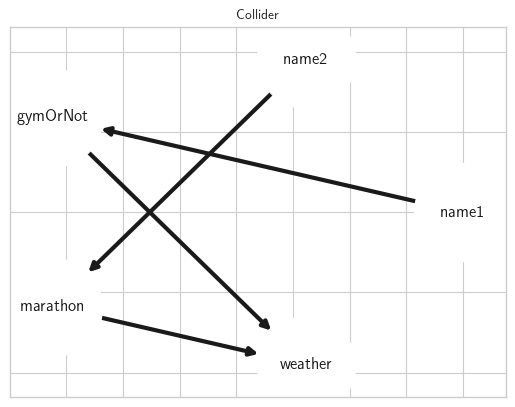

In [6]:
collider_sample_space = [
    {
        'prefix': 'My name is ',
        'suffix': '.',
        'candidate_set': ['John', 'Jane', 'Alice', 'Bob', 'Charlie'],
        'intervention_choice': None,
        'parent_indices': None,
        'exogenous': True,
        'variable_name': 'name1',
    },
    {
        'prefix': 'I know someone named ',
        'suffix': '.',
        'candidate_set': ['John', 'Jane', 'Alice', 'Bob', 'Charlie'],
        'intervention_choice': 'uniform',
        'parent_indices': None,
        'exogenous': True,
        'variable_name': 'name2',
    },
    {
        'prefix': 'I owe it to myself to go ',
        'suffix': '.',
        'candidate_set': ['to the gym', 'for a run outside'],
        'intervention_choice': None,
        'parent_indices': [0],
        'exogenous': False,
        'variable_name': 'gymOrNot',
    },
    {
        'prefix': 'After this, my marathon personal best will ',
        'suffix': '.',
        'candidate_set': ['improve', 'worsen'],
        'intervention_choice': None,
        'parent_indices': [1],
        'exogenous': False,
        'variable_name': 'marathon',
    },
    {
        'prefix': 'Conditions are ',
        'suffix': ' outside in the open air.',
        'candidate_set': ['sunny', 'rainy', 'snowy', 'cold', 'hot'],
        'intervention_choice': None,
        'parent_indices': [2, 3],
        'exogenous': False,
        'variable_name': 'weather',
    },
]

plot_dag_from_sample_space(sequence_sample_space=collider_sample_space, title='Collider')

## Sample collider data

In [7]:
np.random.seed(1)
torch.manual_seed(1)

num_samples = 1000
name_of_intervention = 'gymOrNot'
name_of_outcome = 'marathon'
all_covariates = [setup_dict['variable_name'] for setup_dict in collider_sample_space]

collider_samples = sample_sequences(
    model=model,
    tokenizer=tokenizer,
    sequence_sample_space=collider_sample_space,
    num_samples=num_samples
)

df_samples_collider = format_sequences_as_dataframe(sequences=collider_samples, name_of_intervention=name_of_intervention, name_of_outcome=name_of_outcome, save_logprobs=True)
with pd.option_context('display.max_colwidth', None):
    display(df_samples_collider[['sampled_text']])
    display(df_samples_collider[all_covariates])

print('Sampling counterfactuals...')
np.random.seed(3)
torch.manual_seed(3)
index_of_intervention = np.where([setup_dict['variable_name'] == name_of_intervention for setup_dict in collider_sample_space])[0][0]
collider_cf_samples_do_0 = sample_counterfactual_sequences(
    model=model,
    tokenizer=tokenizer,
    sequence_sample_space=collider_sample_space,
    samples=collider_samples,
    evidence_indices=[],
    index_of_intervention=index_of_intervention,
    intervention_choice=0
)
collider_cf_samples_do_1 = sample_counterfactual_sequences(
    model=model,
    tokenizer=tokenizer,
    sequence_sample_space=collider_sample_space,
    samples=collider_samples,
    evidence_indices=[],
    index_of_intervention=index_of_intervention,
    intervention_choice=1
)
df_collider_cf_samples_do_0 = format_sequences_as_dataframe(sequences=collider_cf_samples_do_0, name_of_intervention=name_of_intervention, name_of_outcome=name_of_outcome)
df_collider_cf_samples_do_1 = format_sequences_as_dataframe(sequences=collider_cf_samples_do_1, name_of_intervention=name_of_intervention, name_of_outcome=name_of_outcome)
print('Done.')

100%|██████████| 1000/1000 [13:57<00:00,  1.19it/s]


,sampled_text
0,"My name is Bob. I know someone named Bob. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are sunny outside in the open air."
1,"My name is Jane. I know someone named Charlie. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are sunny outside in the open air."
2,"My name is Alice. I know someone named John. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are snowy outside in the open air."
3,"My name is Bob. I know someone named Jane. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are rainy outside in the open air."
4,"My name is Bob. I know someone named Bob. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are cold outside in the open air."
...,...
995,"My name is Jane. I know someone named John. I owe it to myself to go for a run outside. After this, my marathon personal best will worsen. Conditions are rainy outside in the open air."
996,"My name is Jane. I know someone named John. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are sunny outside in the open air."
997,"My name is Alice. I know someone named Charlie. I owe it to myself to go for a run outside. After this, my marathon personal best will worsen. Conditions are snowy outside in the open air."
998,"My name is Alice. I know someone named Charlie. I owe it to myself to go to the gym. After this, my marathon personal best will worsen. Conditions are snowy outside in the open air."


,name1,name2,gymOrNot,marathon,weather
0,3,3,0,1,0
1,1,4,0,1,0
2,2,0,0,1,2
3,3,1,0,1,1
4,3,3,0,1,3
...,...,...,...,...,...
995,1,0,1,1,1
996,1,0,0,1,0
997,2,4,1,1,2
998,2,4,0,1,2


Sampling counterfactuals...


100%|██████████| 1000/1000 [08:02<00:00,  2.07it/s]

Done.


# Compare distributions and estimation

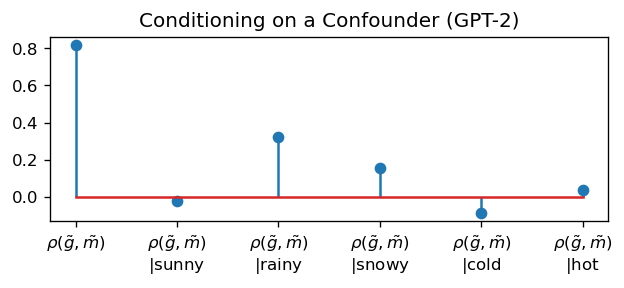

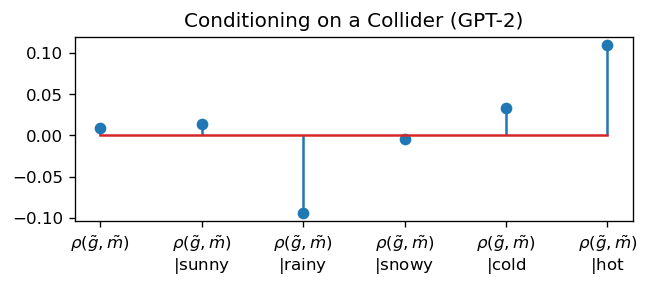

In [22]:
sns.reset_orig()
x_var = 'P(gymOrNot=1)'
y_var = 'P(marathon=1)'
settings = [
    ('Confounder', confounder_sample_space, df_samples_confounder),
    ('Collider', collider_sample_space, df_samples_collider)
]
for (setting_name, sample_space, df) in settings:
    condition_names = [
        name for setup_dict in sample_space 
        for name in setup_dict['candidate_set'] 
        if setup_dict['variable_name'] == 'weather'
    ]
    original_x = df[x_var].values
    original_y = df[y_var].values
    original_name = r'$\rho(\tilde{g}, \tilde{m})$'
    corr_coefs = {original_name: np.corrcoef(x=original_x, y=original_y)[0, 1]}
    for condition in sorted(df['weather'].unique()):
        which_rows = df['weather'] == condition
        x_vals = df[which_rows][x_var].values
        y_vals = df[which_rows][y_var].values
        condition_name = original_name + '\n' + r'$|$' + f'{condition_names[condition]}'
        corr_coefs[condition_name] = np.corrcoef(x=x_vals, y=y_vals)[0, 1]
    ticks = list(range(len(corr_coefs)))
    labels = corr_coefs.keys()
    values = corr_coefs.values()
    plt.figure(figsize=(6, 2), dpi=120)
    plt.title(f'Conditioning on a {setting_name} (GPT-2)')
    plt.xticks(ticks=ticks, labels=labels)
    plt.stem(values)
    # sns.despine()
    # plt.grid(axis='y')
    plt.show()

Setting: Confounder
	SATE: 0.0
	Observational ATE: 0.059301763397664756
	SATE RF prediction with ['weather', 'gymOrNot']: 0.006365544610891114
	SATE RF prediction with ['gymOrNot']: 0.05820306306684344
Setting: Collider
	SATE: 0.0
	Observational ATE: -0.0798349106581584
	SATE RF prediction with ['weather', 'gymOrNot']: -0.1088164574996781
	SATE RF prediction with ['gymOrNot']: -0.08853910887163972


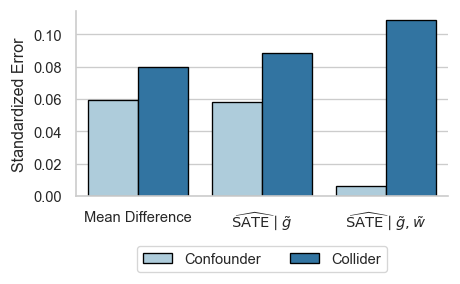

In [32]:
sns.set(font_scale=1, context='paper')
sns.set_style('whitegrid')
np.random.seed(0)

treatment = 'gymOrNot'
outcome = 'P(marathon=1)'
both_covariates = ['weather', treatment]

settings = [
    ('Confounder', df_samples_confounder, df_confounder_cf_samples_do_0, df_confounder_cf_samples_do_1),
    ('Collider', df_samples_collider, df_collider_cf_samples_do_0, df_collider_cf_samples_do_1)
]
estimation_dict = {}
for (setting_name, df, df_do_0, df_do_1) in settings:
    print(f'Setting: {setting_name}')
    sd_outcome = df[outcome].std()
    
    y1 = df_do_1[outcome]
    y0 = df_do_0[outcome]
    ites = (y1 - y0) / sd_outcome
    sate = ites.mean()
    estimation_dict[(0, setting_name, 'sate')] = sate
    print(f'\tSATE: {sate}')
    
    treated_units = df[treatment] == 1
    control_units = df[treatment] == 0
    obs_ate = (df[treated_units][outcome].mean() - df[control_units][outcome].mean()) / sd_outcome
    estimation_dict[(1, setting_name, 'obs_ate')] = obs_ate
    print(f'\tObservational ATE: {obs_ate}')

    for covariates in [both_covariates, [treatment]]:
        rf_model = RandomForestRegressor().fit(X=df[covariates], y=df[outcome])
        X_t1 = df[covariates].copy(deep=True)
        X_t1.loc[:, treatment] = 1
        X_t0 = df[covariates].copy(deep=True)
        X_t0.loc[:, treatment] = 0
        rf_cates = rf_model.predict(X=X_t1) - rf_model.predict(X=X_t0)
        sate_pred = rf_cates.mean() / sd_outcome
        estimation_dict[(2, setting_name, tuple(covariates))] = sate_pred
        print(f'\tSATE RF prediction with {covariates}: {sate_pred}')

confounder_values = [value for key, value in sorted(estimation_dict.items()) if key[1] == 'Confounder']
collider_values = [value for key, value in sorted(estimation_dict.items()) if key[1] == 'Collider']
confounder_errors = list(np.abs(confounder_values[1:]))
collider_errors = list(np.abs(collider_values[1:]))
errors = confounder_errors + collider_errors
names = [r'Mean Difference', r'$\widehat{\text{SATE}} \mid \tilde{g}$', r'$\widehat{\text{SATE}} \mid \tilde{g}, \tilde{w}$'] * 2
dgp_names = ['Confounder'] * 3 + ['Collider'] * 3
df = pd.DataFrame(dict(dgp=dgp_names, name=names, error=errors))
plt.figure(figsize=(4, 2), dpi=120)
sns.barplot(data=df, x='name', y='error', hue='dgp', palette='Paired', edgecolor='black')
plt.ylabel('Standardized Error')
plt.xlabel('')
sns.despine()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=2, fancybox=True, shadow=False)
plt.show()